In [1]:
import torch, torchvision.transforms as T
from torchvision import models
from PIL import Image
import os, glob, pandas as pd, numpy as np, scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from matplotlib import colormaps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import ast


## get alexnet embeddings of stims used in expt

In [100]:
df_subj = pd.read_csv(glob.glob('../results/*tori*')[0])
df_subj = df_subj.dropna(subset=['positions'])
print(len(df_subj))

# sort by trial key
df_subj = df_subj.sort_values(by='trial_key').reset_index(drop=True)

# convert str to list
for col in ['positions']:
    if type(df_subj[col][0]) == str:
        df_subj[col] = df_subj[col].apply(lambda x: ast.literal_eval(x))

# store chosen position
df_subj['chosen_pos'] = df_subj['positions'].apply(lambda x: x[-1])
# store if flipped
df_subj['flipped'] = np.where( df_subj['shape_order'] == 'curv_flat', 0, 1) 
# rename conditions
df_subj['condition'] = df_subj['condition'].map({'baseline': 'baseline', 'pen_comp': 'curv_comp', 'rew_comp': 'flat_comp'})
# store unflipped div_pos
df_subj['div_true'] = df_subj['condition'].map({'baseline': 0, 'curv_comp': -.2, 'flat_comp': .2})
# store correct class
df_subj['class_true'] = np.where( df_subj['shape'] == 'flat', 1, 0 )
# store chosen class
df_subj['class_pred'] = np.where( df_subj['stim_pos'] > df_subj['div_true'], 1, 0 )

df_subj[['target_file', 'blockN', 'condition', 'div_true', 'flipped', 'div_pos', 'stim_pos', 'target_pos', 'chosen_pos', 'class_true', 'class_pred', 'noise_pos']].iloc[55:65]


240


,target_file,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,chosen_pos,class_true,class_pred,noise_pos
55,input_data/stims/Shape_0.70_0.00.png,2.0,curv_comp,-0.2,1,0.2,-0.26,0.26,0.258,0,0,0.0
56,input_data/stims/Shape_0.90_0.00.png,2.0,curv_comp,-0.2,0,-0.2,-0.22,-0.22,-0.165,0,0,0.0
57,input_data/stims/Shape_0.90_0.00.png,2.0,curv_comp,-0.2,1,0.2,-0.22,0.22,0.222,0,0,0.0
58,input_data/stims/Shape_0.90_0.00.png,2.0,curv_comp,-0.2,0,-0.2,-0.22,-0.22,-0.257,0,0,0.0
59,input_data/stims/Shape_0.90_0.00.png,2.0,curv_comp,-0.2,1,0.2,-0.22,0.22,0.304,0,0,0.0
60,input_data/stims/Shape_1.10_4.00.png,2.0,curv_comp,-0.2,0,-0.2,-0.18,-0.18,-0.129,1,1,4.0
61,input_data/stims/Shape_1.10_4.00.png,2.0,curv_comp,-0.2,1,0.2,-0.18,0.18,-0.102,1,1,4.0
62,input_data/stims/Shape_1.30_4.00.png,2.0,curv_comp,-0.2,0,-0.2,-0.14,-0.14,-0.270,1,1,4.0
63,input_data/stims/Shape_1.30_4.00.png,2.0,curv_comp,-0.2,1,0.2,-0.14,0.14,0.228,1,1,4.0
64,input_data/stims/Shape_1.50_4.00.png,2.0,curv_comp,-0.2,0,-0.2,-0.10,-0.10,-0.170,1,1,4.0


In [99]:
# # load pretrainded AlexNet model
# model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# # remove the last layer to get the feature vector
# model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# # transform the input image to the format expected by the model
# transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# def get_embeddings(img_path):
#     img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
#     with torch.no_grad():
#     # with torch.no_grad() is used to disable gradient calculation
#         return model(img)



# # get list of shapes used as targets
# trials_df = pd.read_csv('../input_data/trials_no_noise.csv')
# shape_files_used = trials_df['target_file'].tolist()
# alex_embeds = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in shape_files_used]

# # convert to df
# alexnet_df = pd.DataFrame([(k, *v.squeeze().numpy()) for k, v in alex_embeds])
# alexnet_df.columns = ['shapes'] + [f'feature_{i}' for i in range(alexnet_df.shape[1] - 1)]

# # append associated stim & noise positions
# alexnet_df['stim_file_pos'] = trials_df['stim_file_pos']
# alexnet_df['noise_pos'] = trials_df['noise_pos']
# alexnet_df['div'] = trials_df['condition'].map({'baseline': 2, 'curv_comp': 1, 'flat_comp': 3})

# # append block number
# alexnet_df['block'] = np.repeat(np.arange(len(alexnet_df) // 40) + 1, 40)

# # additional cols based on combinations of conditions
# conditions = [
#     (alexnet_df['stim_file_pos'] < alexnet_df['div']) & (alexnet_df['div'] == 1),
#     (alexnet_df['stim_file_pos'] > alexnet_df['div']) & (alexnet_df['div'] == 1),
#     (alexnet_df['stim_file_pos'] < alexnet_df['div']) & (alexnet_df['div'] == 2),
#     (alexnet_df['stim_file_pos'] > alexnet_df['div']) & (alexnet_df['div'] == 2),
#     (alexnet_df['stim_file_pos'] < alexnet_df['div']) & (alexnet_df['div'] == 3),
#     (alexnet_df['stim_file_pos'] > alexnet_df['div']) & (alexnet_df['div'] == 3),
# ]
# values = [1, 2, 3, 4, 5, 6]
# alexnet_df['ShapeDiv_combo'] = np.select(conditions, values, default=np.nan)

# reorder_columns = ['shapes', 'block', 'div', 'stim_file_pos', 'noise_pos', 'ShapeDiv_combo'] + [col for col in alexnet_df.columns if col.startswith('feature_')]
# alexnet_df = alexnet_df[reorder_columns]

# # remove features with minimal variance across shapes
# feature_cols = [col for col in alexnet_df.columns if col.startswith('feature_')]
# variances = alexnet_df[feature_cols].var()
# threshold = 0.2
# low_variance_features = variances[variances < threshold].index
# alexnet_df = alexnet_df.drop(columns=low_variance_features)

# alexnet_df.to_csv('../input_data/alex_embeds.csv', index=False)

In [ ]:
# load pretrainded AlexNet model
model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# remove the last layer to get the feature vector
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# transform the input image to the format expected by the model
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_embeddings(img_path):
    img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
    with torch.no_grad():
    # with torch.no_grad() is used to disable gradient calculation
        return model(img)
    
    
# 1. Load trial metadata
trials_df = pd.read_csv('../input_data/trials_no_noise.csv')
shape_files_used = trials_df['target_file'].tolist()

# 2. Extract AlexNet embeddings
alex_embeds = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in shape_files_used]
embedding_matrix = np.stack([v.squeeze().numpy() for _, v in alex_embeds])
shape_names = [k for k, _ in alex_embeds]

# 3. Apply PCA to embeddings
n_components = 20
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(embedding_matrix)

# 4. Form DataFrame: shape name + PCA features
pca_cols = [f'feature_{i}' for i in range(pca_features.shape[1])]
alexnet_df = pd.DataFrame(pca_features, columns=pca_cols)
alexnet_df.insert(0, 'shapes', shape_names)

# 5. Append more metadata
alexnet_df[['blockN', 'condition', 'stim_pos', 'target_pos', 'noise_pos', 'div_pos']] = trials_df[['blockN', 'condition', 'stim_pos', 'target_pos', 'noise_pos', 'div_pos']]
alexnet_df['flipped'] = np.where( trials_df['shape_order'] == 'curv_flat', 0, 1) 
alexnet_df['div_true'] = trials_df['condition'].map({'baseline': 0, 'curv_comp': -.2, 'flat_comp': .2})
alexnet_df['class_true'] = np.where( trials_df['shape'] == 'flat', 1, 0 )

# # 7. Combo labels
# conditions = [
#     (alexnet_df['stim_file_pos'] < alexnet_df['div_pos']) & (alexnet_df['div_pos'] == 1),
#     (alexnet_df['stim_file_pos'] > alexnet_df['div_pos']) & (alexnet_df['div_pos'] == 1),
#     (alexnet_df['stim_file_pos'] < alexnet_df['div_pos']) & (alexnet_df['div_pos'] == 2),
#     (alexnet_df['stim_file_pos'] > alexnet_df['div_pos']) & (alexnet_df['div_pos'] == 2),
#     (alexnet_df['stim_file_pos'] < alexnet_df['div_pos']) & (alexnet_df['div_pos'] == 3),
#     (alexnet_df['stim_file_pos'] > alexnet_df['div_pos']) & (alexnet_df['div_pos'] == 3),
# ]
# values = [1, 2, 3, 4, 5, 6]
# alexnet_df['ShapeDiv_combo'] = np.select(conditions, values, default=np.nan)

# 7. Reorder and save
reorder_columns = ['shapes', 'blockN', 'condition', 'div_true', 'flipped', 'div_pos', 'stim_pos', 'target_pos', 'class_true', 'noise_pos'] + pca_cols
# 'class_true'
alexnet_df = alexnet_df[reorder_columns]

alexnet_df.to_csv('../input_data/alex_embeds.csv', index=False)


In [94]:
alexnet_df = pd.read_csv('../input_data/alex_embeds.csv')
print(len(alexnet_df))
alexnet_df.iloc[75:85]

240


,shapes,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,class_true,noise_pos,...,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
75,input_data/stims/Shape_2.50_2.00.png,2,curv_comp,-0.2,1,0.2,0.10,-0.10,1,2.0,...,-1.498267,0.371451,-0.771842,-0.955939,-1.218238,0.480018,-1.092621,0.024547,-0.225427,-0.000036
76,input_data/stims/Shape_2.70_2.00.png,2,curv_comp,-0.2,0,-0.2,0.14,0.14,1,2.0,...,-0.387174,-1.242139,0.594532,0.118062,-0.303566,0.238717,0.968449,-0.818827,0.198698,-0.000036
77,input_data/stims/Shape_2.70_2.00.png,2,curv_comp,-0.2,1,0.2,0.14,-0.14,1,2.0,...,-0.387174,-1.242139,0.594532,0.118062,-0.303566,0.238717,0.968449,-0.818827,0.198698,-0.000036
78,input_data/stims/Shape_2.90_2.00.png,2,curv_comp,-0.2,0,-0.2,0.18,0.18,1,2.0,...,-0.462614,0.253392,-0.499356,0.360493,1.157128,-0.623216,0.216151,0.977740,-0.685693,-0.000036
79,input_data/stims/Shape_2.90_2.00.png,2,curv_comp,-0.2,1,0.2,0.18,-0.18,1,2.0,...,-0.462614,0.253392,-0.499356,0.360493,1.157128,-0.623216,0.216151,0.977740,-0.685693,-0.000036
80,input_data/stims/Shape_1.10_2.00.png,3,flat_comp,0.2,0,0.2,-0.18,-0.18,0,2.0,...,0.707223,0.418053,1.022136,-0.711500,0.305576,0.365254,0.555873,-0.059619,-0.202715,-0.000036
81,input_data/stims/Shape_1.10_2.00.png,3,flat_comp,0.2,1,-0.2,-0.18,0.18,0,2.0,...,0.707223,0.418053,1.022136,-0.711500,0.305576,0.365254,0.555873,-0.059619,-0.202715,-0.000036
82,input_data/stims/Shape_1.30_2.00.png,3,flat_comp,0.2,0,0.2,-0.14,-0.14,0,2.0,...,-0.428711,1.841413,-0.692041,0.928592,-0.573790,-0.476940,0.044567,-0.226658,0.171490,-0.000036
83,input_data/stims/Shape_1.30_2.00.png,3,flat_comp,0.2,1,-0.2,-0.14,0.14,0,2.0,...,-0.428711,1.841413,-0.692041,0.928592,-0.573790,-0.476940,0.044567,-0.226658,0.171490,-0.000036
84,input_data/stims/Shape_1.50_2.00.png,3,flat_comp,0.2,0,0.2,-0.10,-0.10,0,2.0,...,0.358241,-1.731844,0.203042,-1.043817,0.514890,0.253732,-0.468895,0.360721,-0.100115,-0.000036


## plot stim embeddings from alexnet

alex_embeds_df.shape (n_trials, n_feats): (240, 20)


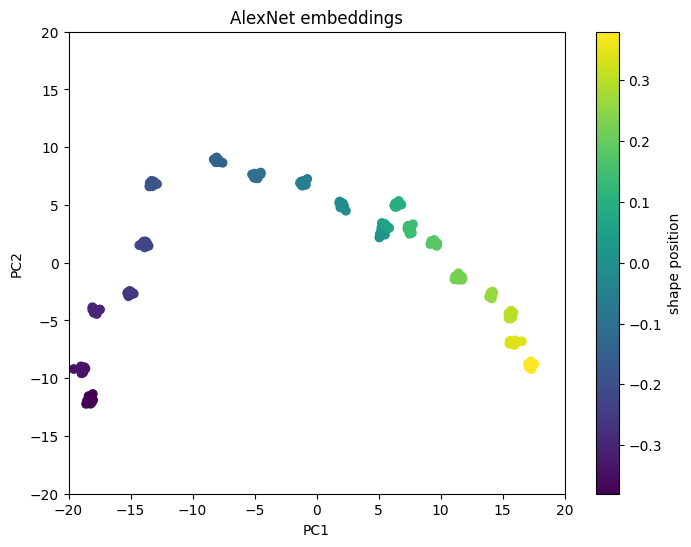

In [101]:
# sub-select cols
alex_embeds_df = alexnet_df[alexnet_df.columns[alexnet_df.columns.str.startswith('feature_')]]
print(f'alex_embeds_df.shape (n_trials, n_feats): {alex_embeds_df.shape}')

pca = PCA(n_components=2)
alex_feat_pc_df = pd.DataFrame(pca.fit_transform(alex_embeds_df),
                               columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
jitter = .2
scatter = plt.scatter(alex_feat_pc_df['PC1'] + np.random.normal(0, jitter, size=len(alex_feat_pc_df)),
                      alex_feat_pc_df['PC2'] + np.random.normal(0, jitter, size=len(alex_feat_pc_df)),
                      c = alexnet_df['stim_pos'].values)

plt.colorbar(scatter, label='shape position')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('AlexNet embeddings')
plt.show()


## building architecture of new NN

In [102]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class ShapeSideNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, recon_dim, class_dim):
        super(ShapeSideNN, self).__init__()
        
        # single intermediate layer
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        # separate outputs
        self.reconstruction_output = nn.Linear(hidden_dim, recon_dim)
        self.classification_output = nn.Linear(hidden_dim, class_dim)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        
        # output for reconstruction (continuous)
        reconstruction = self.reconstruction_output(x)
        
        # sigmoid output for classification (binary)
        # classification = torch.sigmoid(self.classification_output(x))
        classification = self.classification_output(x)
        
        return reconstruction, classification

## format features (X) & predictions (y_recon & y_class)

In [103]:
# 1.
feature_cols = [col for col in alexnet_df.columns if col.startswith('feature_')]
# features = alex embeds + div_pos + flipped
X = np.column_stack((alexnet_df[feature_cols].values,
                     alexnet_df['div_pos'].values,alexnet_df['flipped'].values))

# 2.
y_class = alexnet_df['class_true'].values.reshape(-1, 1) # shape class (0 or 1)

# 3.
y_reg = alexnet_df['target_pos'].values.reshape(-1, 1) # regression target
# y_reg = df_subj['chosen_pos'].values.reshape(-1, 1)

print(f'X.shape (n_trials, n_feats + div_cntxt): {X.shape}')

X.shape (n_trials, n_feats + div_cntxt): (240, 22)


## cross-validation

stopped at epoch 420
# false pos: 12
# false neg: 14
accuracy: 0.783


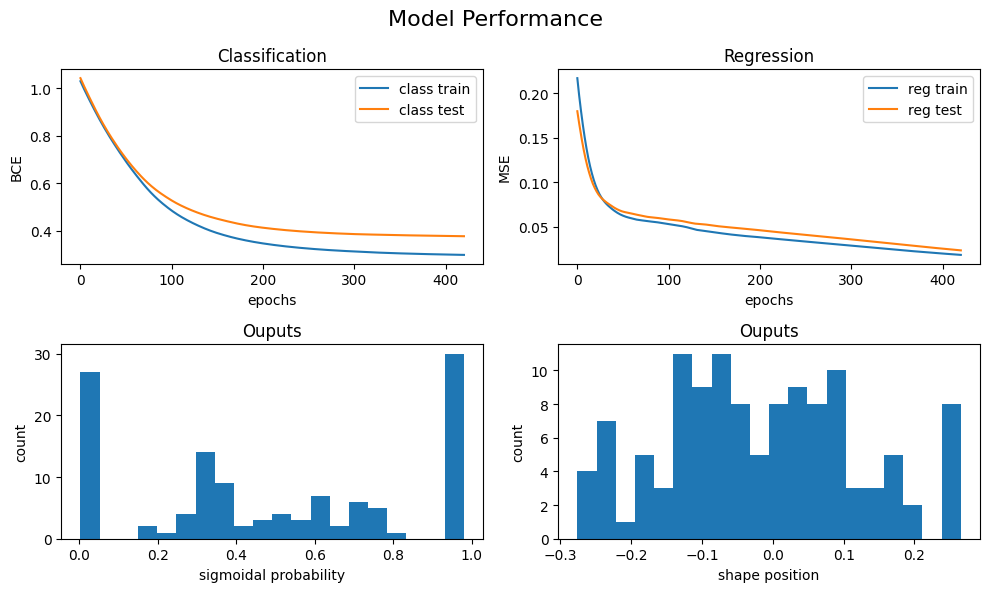

In [104]:
# architecture params
input_dim, hidden_dim, reg_dim, class_dim = X.shape[1], 10, y_reg.shape[1], 1
model = ShapeSideNN(input_dim, hidden_dim, reg_dim, class_dim)

# loss params
optimizer = optim.Adam(model.parameters(), lr=0.001)
reg_wt, class_wt, fp_wt = .5, .5, 1.0

# split into train and test once
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_reg, y_class, test_size=.5, stratify=y_class, shuffle=True
)

train_total_losses, train_reg_losses, train_class_losses = [], [], []
test_total_losses, test_reg_losses, test_class_losses = [], [], []
epochs = 1000

# training loop
for epoch in range(epochs):
    model.train()

    # forward pass to predict regstruction & class
    pred_reg_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))

    # 1. regstruction loss between pred & y
    train_reg_loss = nn.MSELoss()(pred_reg_train,
                                    torch.tensor(y_reg_train, dtype=torch.float32))

    # 2. classification loss 
    train_class_loss = nn.BCEWithLogitsLoss()(pred_class_train,
                                              torch.tensor(y_class_train, dtype=torch.float32))
    
    # no reduction means in unpacks/doesnt take mean across samples
    bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_train,
                                                 torch.tensor(y_class_train, dtype=torch.float32))
    # weight vector per sample, taking the form: y_true = 1 + y_true = 0
    weights = torch.tensor(y_class_train, dtype=torch.float32) + fp_wt * (1 - torch.tensor(y_class_train, dtype=torch.float32))
    # expected weighted error
    train_class_loss = (weights * bce).mean()

    # 3. weighted summed training loss
    train_total_loss = reg_wt * train_reg_loss + class_wt * train_class_loss

    # backward pass and optimization
    optimizer.zero_grad()
    train_total_loss.backward()
    # to try to take care of exploding gradients (manifested as sudden, high losses)?
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # testing model
    model.eval()
    with torch.no_grad():

        # predict test shape & class using trained model
        pred_reg_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))        

        # 1. reg losses between pred & y
        test_reg_loss = nn.MSELoss()(pred_reg_test, torch.tensor(y_reg_test, dtype=torch.float32))

        # 2. class loss
        test_class_loss = nn.BCEWithLogitsLoss()(pred_class_test,
                                                 torch.tensor(y_class_test, dtype=torch.float32))
        bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_test,
                                                     torch.tensor(y_class_test, dtype=torch.float32))
        weights = torch.tensor(y_class_test, dtype=torch.float32) + fp_wt * (1 - torch.tensor(y_class_test, dtype=torch.float32))
        test_class_loss = (weights * bce).mean()
        
        # 3. weighted summed testing loss
        test_total_loss = reg_wt * test_reg_loss + class_wt * test_class_loss

    # appending train & test losses
    train_reg_losses.append(train_reg_loss.item())
    train_class_losses.append(train_class_loss.item())
    train_total_losses.append(train_total_loss.item())

    test_reg_losses.append(test_reg_loss.item())
    test_class_losses.append(test_class_loss.item())
    test_total_losses.append(test_total_loss.item())

    # stop early
    if test_total_loss.item() <= .2:
        print(f'stopped at epoch {epoch}')
        break


fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs, ax = axs.flatten(), 0
fig.suptitle('Model Performance', fontsize=16)

# 1. class loss
axs[ax].plot(train_class_losses, label='class train')
axs[ax].plot(test_class_losses, label='class test')
axs[ax].set_xlabel('epochs')
axs[ax].set_ylabel('BCE')
# axs[0].set_ylim(0, 5)
axs[ax].set_title('Classification')
axs[ax].legend()
ax += 1

# 2. reg loss
axs[ax].plot(train_reg_losses, label='reg train')
axs[ax].plot(test_reg_losses, label='reg test')
axs[ax].set_xlabel('epochs')
axs[ax].set_ylabel('MSE')
# axs[0].set_ylim(0, 5)
axs[ax].set_title('Regression')
axs[ax].legend()
ax += 1

# 3. classification: sigmoidal probabilities
sigmoid_probs = torch.sigmoid(pred_class_test).detach().numpy()

false_pos = np.sum((sigmoid_probs > .5) & (y_class_test == 0))
print(f'# false pos: {false_pos}')
false_neg = np.sum((sigmoid_probs < .5) & (y_class_test == 1))
print(f'# false neg: {false_neg}')
print(f'accuracy: {(len(sigmoid_probs) - false_pos - false_neg) / len(sigmoid_probs):.3f}')

axs[ax].hist(sigmoid_probs, bins=20)
axs[ax].set_xlabel('sigmoidal probability')
axs[ax].set_ylabel('count')
axs[ax].set_title('Ouputs')
ax += 1

# 4. regression to shape position
reg_outputs = pred_reg_test.numpy()
axs[ax].hist(reg_outputs, bins=20)
axs[ax].set_xlabel('shape position')
axs[ax].set_ylabel('count')
axs[ax].set_title('Ouputs')

plt.tight_layout()
plt.show()



## reward-based supervised training

In [80]:
# from sklearn.model_selection import train_test_split

# # architecture params
# # input_dim, hidden_dim, output_dim = n_feats+1, 128, n_feats+1
# input_dim, hidden_dim, recon_dim, class_dim = X.shape[1], 128, y_recon.shape[1], 1
# model = ShapeSideNN(input_dim, hidden_dim, recon_dim, class_dim)

# # loss params
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = .5, .5

# # reward matrix: (true_label, predicted_label) → reward
# reward_matrix = {
#     (1, 1): 3,   # true positive
#     (0, 0): 1,   # true negative
#     (1, 0): -1,  # false negative
#     (0, 1): -3   # false positive
# }
# # negation to cast as loss
# cost_matrix = {k: -v for k, v in reward_matrix.items()}

# # split into train and test once
# X_train, X_test, y_recon_train, y_recon_test, y_class_train, y_class_test = train_test_split(
#     X, y_recon, y_class, test_size=.6, random_state=42, shuffle=True
# )

# train_total_losses, train_recon_losses, train_class_losses = [], [], []
# test_total_losses, test_recon_losses, test_class_losses = [], [], []
# epochs = 2000

# # training loop
# for epoch in range(epochs):
#     model.train()

#     # forward pass to predict reconstruction & class
#     pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))

#     # 1. reconstruction loss between pred & y
#     train_recon_loss = nn.MSELoss()(pred_recon_train,
#                                     torch.tensor(y_recon_train, dtype=torch.float32))

#     # 2. classification loss 
#     # get binary predicted class from logits
#     sigmoids = (torch.sigmoid(pred_class_train) >= .5).float()

#     # map (true, pred) → cost
#     weights = torch.tensor([
#         cost_matrix[(t.item(), p.item())] for t, p in zip(y_class_train, sigmoids)
#     ], dtype=torch.float32).unsqueeze(1)

#     # compute loss per sample, then apply cost-based weights
#     bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_train,
#                                                  torch.tensor(y_class_train, dtype=torch.float32))
#     train_class_loss = (weights * bce).mean()

#     # 3. weighted summed training loss
#     train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#     # backward pass and optimization
#     optimizer.zero_grad()
#     train_total_loss.backward()
#     # to try to take care of exploding gradients (manifested as sudden, high losses)?
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#     optimizer.step()

#     # testing model
#     model.eval()
#     with torch.no_grad():

#         # predict test shape & class using trained model
#         pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))        

#         # 1. recon losses between pred & y
#         test_recon_loss = nn.MSELoss()(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))

#         # 2. class loss
#         # get binary predicted class from logits
#         sigmoids = (torch.sigmoid(pred_class_test) >= .5).float()

#         # map (true, pred) → cost
#         weights = torch.tensor([
#             cost_matrix[(t.item(), p.item())] for t, p in zip(y_class_test, sigmoids)
#         ], dtype=torch.float32).unsqueeze(1)

#         # compute loss per sample, then apply cost-based weights
#         bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_test,
#                                                     torch.tensor(y_class_test, dtype=torch.float32))
#         test_class_loss = (weights * bce).mean()

#         # 3. weighted summed training loss
#         train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # 3. weighted summed testing loss
#         test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

#     # appending train & test losses
#     train_recon_losses.append(train_recon_loss.item())
#     train_class_losses.append(train_class_loss.item())
#     train_total_losses.append(train_total_loss.item())

#     test_recon_losses.append(test_recon_loss.item())
#     test_class_losses.append(test_class_loss.item())
#     test_total_losses.append(test_total_loss.item())


# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# axs, ax = axs.flatten(), 0
# fig.suptitle('Model Performance', fontsize=16)

# # loss curves
# axs[ax].plot(train_total_losses, label='train')
# axs[ax].plot(test_total_losses, label='test')
# axs[ax].set_xlabel('epochs')
# axs[ax].set_ylabel('loss')
# # axs[0].set_ylim(0, 5)
# axs[ax].set_title('Loss Reduction')
# axs[ax].legend()
# ax += 1

# # sigmoidal probabilities
# sigmoids = torch.sigmoid(pred_class_test).detach().numpy()
# # print(f'Binary classification accuracy: {np.mean((sigmoids > 0.5) == y_class_test.numpy())}')
# print('≈0:', np.sum(sigmoids < .5), ', ≈1:', np.sum(sigmoids > .5))
# print('True classes:', np.bincount(y_class_test.squeeze().astype(int)))
# axs[ax].hist(sigmoids, bins=20)
# axs[ax].set_xlabel('sigmoidal probability')
# axs[ax].set_ylabel('count')
# axs[ax].set_title('Binary outputs')
# ax += 1

# # true predictions
# model_outputs = pred_class_test.numpy()
# # print min and max
# print(f'min: {np.min(model_outputs)}, max: {np.max(model_outputs)}')
# axs[ax].hist(model_outputs, bins=20)
# axs[ax].set_xlabel('model outputs')
# axs[ax].set_ylabel('count')
# axs[ax].set_title('Continuous outputs')

# plt.tight_layout()
# plt.show()



In [105]:
# Get hidden layer activations
with torch.no_grad():
    nn_hidden = model.hidden(torch.tensor(X, dtype=torch.float32)).numpy()

# create column names and convert to df
hidden_cols = [f'hidden_{i}' for i in range(nn_hidden.shape[1])]
hidden_df = pd.DataFrame(nn_hidden, columns=hidden_cols)
print(f'nn_hidden_df.shape (n_trials, n_hidden_units): {hidden_df.shape}')

nn_df = pd.concat([alexnet_df.drop(columns=[col for col in alexnet_df.columns if col.startswith('features_')]),
                   hidden_df], axis=1)
nn_df.head()

nn_hidden_df.shape (n_trials, n_hidden_units): (240, 10)


,shapes,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,class_true,noise_pos,...,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,hidden_6,hidden_7,hidden_8,hidden_9
0,input_data/stims/Shape_0.10_2.00.png,1,baseline,0.0,0,0.0,-0.38,-0.38,0,2.0,...,-0.324783,-5.657469,-2.761412,-1.681404,5.949944,3.138077,1.508957,8.138457,-4.337541,4.846737
1,input_data/stims/Shape_0.10_2.00.png,1,baseline,0.0,1,0.0,-0.38,0.38,0,2.0,...,-0.651668,-5.905603,-2.779849,-1.517535,6.108027,2.675834,1.243813,7.748037,-3.808807,5.020122
2,input_data/stims/Shape_0.30_2.00.png,1,baseline,0.0,0,0.0,-0.34,-0.34,0,2.0,...,-0.159078,-4.676995,-2.940409,-1.099982,4.911631,4.111847,1.219058,8.708571,-2.898439,5.414824
3,input_data/stims/Shape_0.30_2.00.png,1,baseline,0.0,1,0.0,-0.34,0.34,0,2.0,...,-0.485963,-4.925131,-2.958847,-0.936114,5.069716,3.649604,0.953914,8.318157,-2.369710,5.588212
4,input_data/stims/Shape_0.50_2.00.png,1,baseline,0.0,0,0.0,-0.30,-0.30,0,2.0,...,0.584019,-3.359152,-2.470873,-1.821427,2.673695,4.197495,0.345945,8.364882,-3.229038,4.438797


## visualize hidden layer

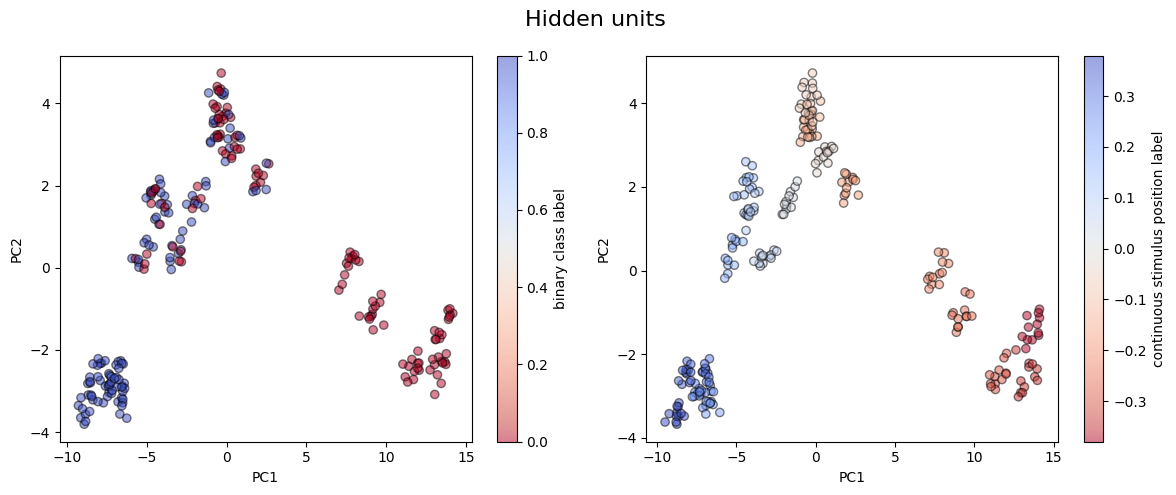

In [106]:
pca = PCA(n_components=2)
hidden_pc = pca.fit_transform(hidden_df)
hidden_pc_df = pd.DataFrame(hidden_pc, columns=['PC1', 'PC2'])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs, ax = axs.flatten(), 0
fig.suptitle('Hidden units', fontsize=16)

scatter1 = axs[0].scatter(hidden_pc_df['PC1'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          hidden_pc_df['PC2'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          c = alexnet_df['class_true'], cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
fig.colorbar(scatter1, ax=axs[0], label='binary class label')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
ax += 1

scatter2 = axs[1].scatter(hidden_pc_df['PC1'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          hidden_pc_df['PC2'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          c = alexnet_df['stim_pos'], cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
fig.colorbar(scatter2, ax=axs[1], label='continuous stimulus position label')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')

plt.tight_layout()
plt.show()


## comparing class clusters

mid_space_df.shape (n_select_trials, n_hidden_units): (120, 10)
class0_df.shape (n_select_trials, n_hidden_units): (120, 10)
class1_df.shape (n_select_trials, n_hidden_units): (120, 10)


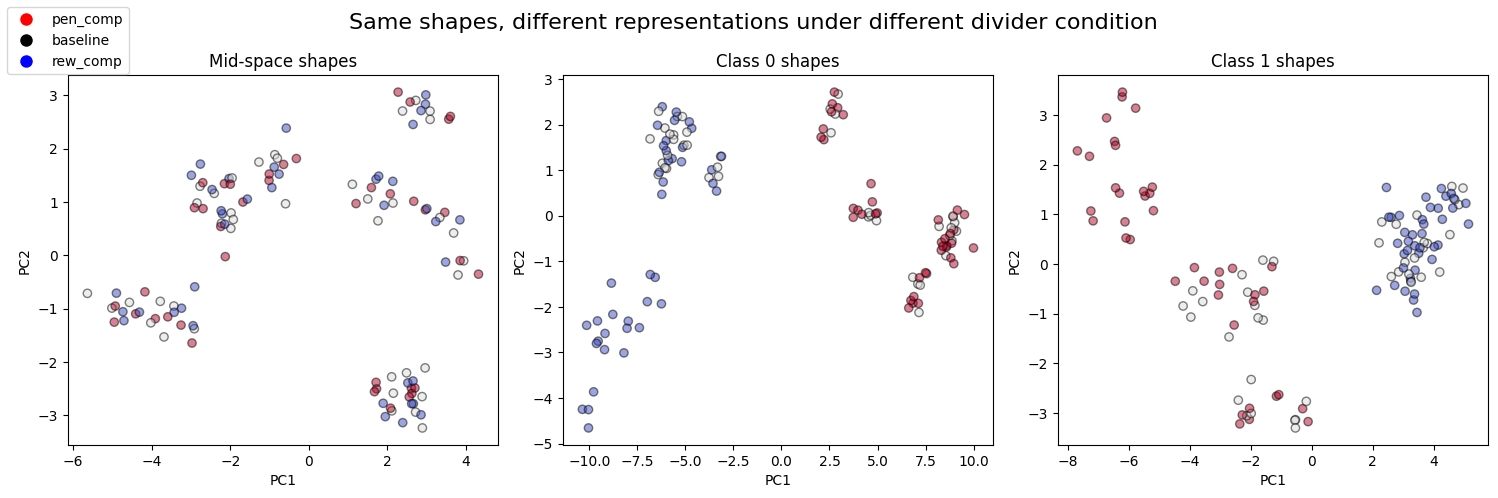

In [112]:
# 1.
mid_ids = alexnet_df[(alexnet_df['stim_pos'] >= -.2) & (alexnet_df['stim_pos'] <= .2)].index
mid_space_df = hidden_df.iloc[mid_ids]
print(f'mid_space_df.shape (n_select_trials, n_hidden_units): {mid_space_df.shape}')

pca = PCA(n_components=2)
mid_space_pc_df = pd.DataFrame(pca.fit_transform(mid_space_df), columns=['PC1', 'PC2'])

# 2.
class0_ids = alexnet_df[alexnet_df['class_true'] == 0].index
class0_df = hidden_df.iloc[class0_ids]
print(f'class0_df.shape (n_select_trials, n_hidden_units): {class0_df.shape}')

class1_ids = alexnet_df[alexnet_df['class_true'] == 1].index
class1_df = hidden_df.iloc[class1_ids]
print(f'class1_df.shape (n_select_trials, n_hidden_units): {class1_df.shape}')

pca = PCA(n_components=2)
class0_pc_df = pd.DataFrame(pca.fit_transform(class0_df), columns=['PC1', 'PC2'])
class1_pc_df = pd.DataFrame(pca.fit_transform(class1_df), columns=['PC1', 'PC2'])

# plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs, ax = axs.flatten(), 0
fig.suptitle('Same shapes, different representations under different divider condition', fontsize=16)
jitter = .3
condition_colors = {'pen_comp': 'red', 'baseline': 'black', 'rew_comp': 'blue'}
colors = alexnet_df['div_true'].map(condition_colors)

# a
scatter1 = axs[ax].scatter(mid_space_pc_df['PC1'] + np.random.normal(0, jitter, size=len(mid_space_pc_df)),
                           mid_space_pc_df['PC2'] + np.random.normal(0, jitter, size=len(mid_space_pc_df)),
                           c = alexnet_df['div_true'].iloc[mid_ids].values, cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
axs[ax].set_title('Mid-space shapes')
ax += 1

# b
scatter1 = axs[ax].scatter( class0_pc_df['PC1'] + np.random.normal(0, jitter, size=len(class0_pc_df)),
                            class0_pc_df['PC2'] + np.random.normal(0, jitter, size=len(class0_pc_df)),
                            c = alexnet_df['div_true'].iloc[mid_ids].values, cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
axs[ax].set_title('Class 0 shapes')
ax += 1

# c
scatter1 = axs[ax].scatter( class1_pc_df['PC1'] + np.random.normal(0, jitter, size=len(class1_pc_df)),
                            class1_pc_df['PC2'] + np.random.normal(0, jitter, size=len(class1_pc_df)),
                            c = alexnet_df['div_true'].iloc[mid_ids].values, cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
axs[ax].set_title('Class 1 shapes')
ax += 1

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='pen_comp', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='baseline', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='rew_comp', markerfacecolor='blue', markersize=10)
]

fig.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


## distance from neutral

In [150]:
nn_df.head()

,shapes,block,div,stim_file_pos,noise_pos,ShapeDiv_combo,feature_0,feature_1,feature_2,feature_3,...,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,hidden_6,hidden_7,hidden_8,hidden_9
0,input_data/stims/Shape_0.10_2.00.png,1,2,0.1,2.0,3.0,-18.188423,-11.822997,-6.470755,1.249775,...,-0.160827,-4.912815,1.369329,-1.859486,1.445437,-7.930568,-2.093366,-7.345022,5.916422,1.257290
1,input_data/stims/Shape_0.10_2.00.png,1,2,0.1,2.0,3.0,-18.188425,-11.823001,-6.470753,1.249772,...,-0.160827,-4.912816,1.369329,-1.859486,1.445438,-7.930568,-2.093364,-7.345024,5.916423,1.257290
2,input_data/stims/Shape_0.30_2.00.png,1,2,0.3,2.0,3.0,-19.039953,-9.294903,-1.582752,1.060145,...,0.301735,-5.114816,0.592221,-1.214352,2.434347,-6.234419,-0.640133,-5.126893,4.656471,-0.942213
3,input_data/stims/Shape_0.30_2.00.png,1,2,0.3,2.0,3.0,-19.039953,-9.294903,-1.582753,1.060146,...,0.301735,-5.114817,0.592221,-1.214352,2.434347,-6.234419,-0.640134,-5.126894,4.656471,-0.942214
4,input_data/stims/Shape_0.50_2.00.png,1,2,0.5,2.0,3.0,-17.791555,-4.115098,2.448457,1.719272,...,0.257393,-2.831567,-0.807520,-0.924040,2.309576,-4.609076,-0.099598,-2.843145,2.360236,-1.607280


In [151]:
# 1. get 1D distance of each shape from divider
nn_df['1D_dist_frm_div'] = nn_df['stim_file_pos'] - nn_df['div']

# 2. get euclidean distance of each shape from divider
euc_dists = []

for shape_id in range(len(nn_df)):

    div = nn_df['div'].iloc[shape_id]

    # get indices of shapes to the immediate left and right of the divider
    left_of_div_shape = f'input_data/stims/Shape_{div-.1}0_2.00.png'
    left_of_div_id = nn_df[nn_df['shapes'] == left_of_div_shape].index[0]

    right_of_div_shape = f'input_data/stims/Shape_{div+.1}0_2.00.png'
    right_of_div_id = nn_df[nn_df['shapes'] == right_of_div_shape].index[0]

    # compute centroid between shapes immediately left & right of div
    centroid = np.mean([
        hidden_df.iloc[left_of_div_id].values,
        hidden_df.iloc[right_of_div_id].values
    ], axis=0)

    # store euclidean distance betw. shape and centroid
    euc_dist = np.linalg.norm(hidden_df.iloc[shape_id].values - centroid)
    euc_dists.append(euc_dist)

nn_df['euc_dist_frm_div'] = euc_dists
nn_df.head(10)


,shapes,block,div,stim_file_pos,noise_pos,ShapeDiv_combo,feature_0,feature_1,feature_2,feature_3,...,hidden_2,hidden_3,hidden_4,hidden_5,hidden_6,hidden_7,hidden_8,hidden_9,1D_dist_frm_div,euc_dist_frm_div
0,input_data/stims/Shape_0.10_2.00.png,1,2,0.1,2.0,3.0,-18.188423,-11.822997,-6.470755,1.249775,...,1.369329,-1.859486,1.445437,-7.930568,-2.093366,-7.345022,5.916422,1.257290,-1.9,16.703800
1,input_data/stims/Shape_0.10_2.00.png,1,2,0.1,2.0,3.0,-18.188425,-11.823001,-6.470753,1.249772,...,1.369329,-1.859486,1.445438,-7.930568,-2.093364,-7.345024,5.916423,1.257290,-1.9,16.703802
2,input_data/stims/Shape_0.30_2.00.png,1,2,0.3,2.0,3.0,-19.039953,-9.294903,-1.582752,1.060145,...,0.592221,-1.214352,2.434347,-6.234419,-0.640133,-5.126893,4.656471,-0.942213,-1.7,14.174595
3,input_data/stims/Shape_0.30_2.00.png,1,2,0.3,2.0,3.0,-19.039953,-9.294903,-1.582753,1.060146,...,0.592221,-1.214352,2.434347,-6.234419,-0.640134,-5.126894,4.656471,-0.942214,-1.7,14.174595
4,input_data/stims/Shape_0.50_2.00.png,1,2,0.5,2.0,3.0,-17.791555,-4.115098,2.448457,1.719272,...,-0.807520,-0.924040,2.309576,-4.609076,-0.099598,-2.843145,2.360236,-1.607280,-1.5,10.423066
5,input_data/stims/Shape_0.50_2.00.png,1,2,0.5,2.0,3.0,-17.791555,-4.115098,2.448457,1.719272,...,-0.807520,-0.924040,2.309577,-4.609075,-0.099598,-2.843145,2.360236,-1.607279,-1.5,10.423067
6,input_data/stims/Shape_0.70_2.00.png,1,2,0.7,2.0,3.0,-15.006859,-2.686474,3.978524,0.059783,...,-0.746433,-1.546632,3.265801,-3.674783,-0.338254,-2.731345,2.123477,-0.753010,-1.3,9.705719
7,input_data/stims/Shape_0.70_2.00.png,1,2,0.7,2.0,3.0,-15.006859,-2.686474,3.978524,0.059783,...,-0.746433,-1.546632,3.265801,-3.674783,-0.338254,-2.731345,2.123477,-0.753010,-1.3,9.705719
8,input_data/stims/Shape_0.90_2.00.png,1,2,0.9,2.0,3.0,-13.753590,1.690720,4.023210,-2.213811,...,-1.929719,-1.857247,3.021183,-2.386540,0.316264,-1.774226,2.989827,-2.465413,-1.1,9.528415
9,input_data/stims/Shape_0.90_2.00.png,1,2,0.9,2.0,3.0,-13.753590,1.690720,4.023210,-2.213811,...,-1.929719,-1.857246,3.021183,-2.386539,0.316264,-1.774226,2.989827,-2.465413,-1.1,9.528415


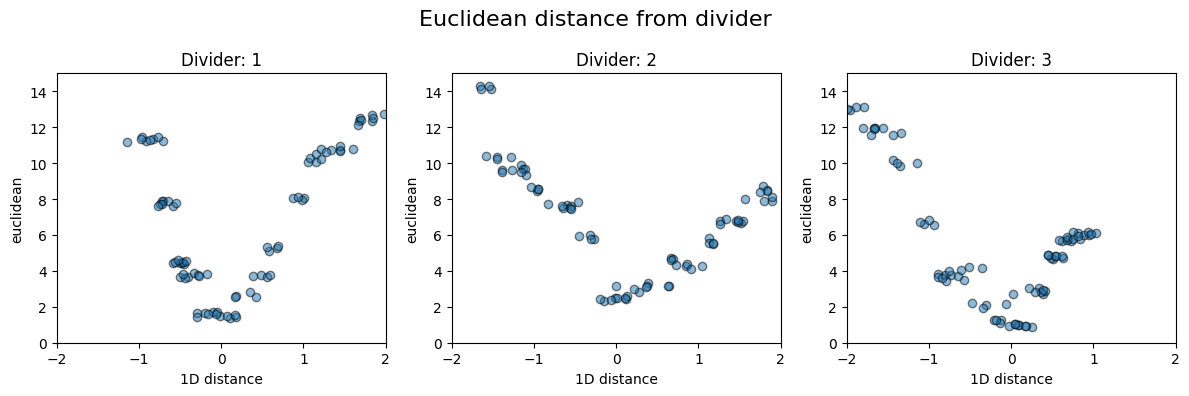

In [152]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs, ax = axs.flatten(), 0
fig.suptitle('Euclidean distance from divider', fontsize=16)
jitter = .1

for div, div_df in nn_df.groupby('div'):

    # plot euc dist (y) vs. 1D dist (x)
    scatter = axs[ax].scatter(div_df['1D_dist_frm_div'] + np.random.normal(0, jitter, size=len(div_df)),
                              div_df['euc_dist_frm_div'] + np.random.normal(0, jitter, size=len(div_df)),
                              edgecolor='k', alpha=0.5, marker='o')

    axs[ax].set_xlabel('1D distance')
    axs[ax].set_ylabel('euclidean')
    axs[ax].set_title(f'Divider: {div}')
    axs[ax].set_ylim(0, 15)
    axs[ax].set_xlim(-2, 2)
    ax += 1

plt.tight_layout()
plt.show()

## k-fold CV

In [56]:
# from sklearn.model_selection import KFold

# # architecture params
# input_dim, hidden_dim, output_dim = n_feats, 128, n_feats
# model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# # loss params
# recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = 0, 5

# # convert to numpy arrays for compatibility with KFold
# X, y_recon, y_class = np.array(X), np.array(y_recon), np.array(y_class)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# fold_total_losses, fold_recon_losses, fold_class_losses = [], [], []
# epochs = 2500

# # CV loop
# for fold, (train_id, test_id) in enumerate(kf.split(X)):

#     print(f'fold {fold+1}', end=', ')

#     # split into train and test
#     X_train, X_test = X[train_id], X[test_id]
#     y_recon_train, y_recon_test = y_recon[train_id], y_recon[test_id]
#     y_class_train, y_class_test = y_class[train_id], y_class[test_id]

#     # initialize model, loss, and optimizer
#     model = ShapeSideNN(input_dim, hidden_dim, output_dim)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     epoch_total_losses, epoch_recon_losses, epoch_class_losses = [], [], []
#     beta = 3.0
#     # training loop
#     for epoch in range(epochs):
#         model.train()

#         # forward pass to predict reconstruction & class
#         pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))
#         pred_class_train = torch.sigmoid(pred_class_train)

#         # calculate training losses between pred & y
#         train_recon_loss = recon_loss_fn(pred_recon_train, torch.tensor(y_recon_train, dtype=torch.float32))
#         train_class_loss = class_loss_fn(pred_class_train, torch.tensor(y_class_train, dtype=torch.float32))
#         # weighted sum
#         train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # backward pass and optimization; training
#         optimizer.zero_grad()
#         train_total_loss.backward()
#         optimizer.step()

#         # testing model
#         model.eval()
#         test_total_losses, test_recon_losses, test_class_losses = [], [], []
#         with torch.no_grad():

#             # predict left-out (test) shape & class based using trained model on left-out embeddings
#             pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))
#             pred_class_test = torch.sigmoid(pred_class_test)

#             # calculate testing losses between pred & y
#             test_recon_loss = recon_loss_fn(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))
#             test_class_loss = class_loss_fn(pred_class_test, torch.tensor(y_class_test, dtype=torch.float32))
#             test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

#         # appending epoch losses
#         epoch_recon_losses.append(test_recon_loss.item())
#         epoch_class_losses.append(test_class_loss.item())
#         epoch_total_losses.append(test_total_loss.item())

#     # appending fold losses
#     fold_recon_losses.append(epoch_recon_losses)
#     fold_class_losses.append(epoch_class_losses)
#     fold_total_losses.append(epoch_total_losses)

# # plot losses
# plt.figure(figsize=(8, 5))
# for i in range(5):
#     plt.plot(fold_total_losses[i], label=f'fold {i+1} class loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('5-fold CV')
# plt.legend()
# plt.show()
